<a href="https://colab.research.google.com/github/gwangmin/AutoEncoders/blob/master/ae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import

from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# load, reshape, normalize MNIST dataset

(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_sz = (x_train.shape[1], x_train.shape[1], 1)
x_train = np.reshape(x_train, [-1, img_sz[0], img_sz[1], img_sz[2]])
x_test = np.reshape(x_test, [-1, img_sz[0], img_sz[1], img_sz[2]])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11493376/11490434 [==============================] - 2s 0us/step


In [0]:
# define Model(Image AutoEncoder)

class Img_AE:
    '''
    Image AutoEncoder
    Architecture: Input - Conv2D - Conv2D - Dense - Latent vector - Dense - Conv2DTranspose - Conv2DTranspose - Output
    member:
        encoder - Encoder
        decoder - Decoder
        ae - Entire AutoEncoder
    '''
    def __init__(self, img_sz, z_dim):
        '''
        Initializer
        '''
        self.img_sz = img_sz
        self.z_dim = z_dim
        self.build_ae()
    
    def build_encoder(self):
        '''
        Build encoder
        '''
        self.input = Input(shape=self.img_sz, name='encoder_input')
        e = Conv2D(32, 3, strides=1, padding='same', activation='relu')(self.input)
        e = Conv2D(64, 3, strides=1, padding='same', activation='relu')(e)
        self.shape = K.int_shape(e)
        e = Flatten()(e)
        z = Dense(self.z_dim, name='latent_vector')(e)
        self.encoder = Model(inputs=self.input, outputs=z, name='encoder')
    
    def build_decoder(self):
        '''
        Build decoder
        '''
        z_input = Input(shape=(self.z_dim,), name='decoder_input')
        d = Dense(self.shape[1] * self.shape[2] * self.shape[3])(z_input)
        d = Reshape((self.shape[1], self.shape[2], self.shape[3]))(d)
        d = Conv2DTranspose(64, 3, strides=1, padding='same', activation='relu')(d)
        d = Conv2DTranspose(32, 3, strides=1, padding='same', activation='relu')(d)
        d = Conv2DTranspose(1, 3, strides=1, padding='same', activation='sigmoid', name='decoder_output')(d)
        self.decoder = Model(inputs=z_input, outputs=d, name='decoder')
    
    def build_ae(self):
        '''
        Build entire autoencoder
        '''
        # Encoder
        self.build_encoder()
        # Decoder
        self.build_decoder()
        # Connect
        self.ae = Model(inputs=self.input, outputs=self.decoder(self.encoder(self.input)))
        self.ae.compile(optimizer='adam', loss='mse')

In [0]:
# Train

epochs = 20
batch_size = 32

ae = Img_AE(img_sz, 2)
his = ae.ae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 38s 630us/step - loss: 0.0518 - val_loss: 0.0455
Epoch 2/20
60000/60000 [==============================] - 37s 618us/step - loss: 0.0445 - val_loss: 0.0434
Epoch 3/20
60000/60000 [==============================] - 37s 615us/step - loss: 0.0430 - val_loss: 0.0425
Epoch 4/20
60000/60000 [==============================] - 37s 621us/step - loss: 0.0422 - val_loss: 0.0423
Epoch 5/20
60000/60000 [==============================] - 38s 630us/step - loss: 0.0416 - val_loss: 0.0421
Epoch 6/20
60000/60000 [==============================] - 37s 620us/step - loss: 0.0412 - val_loss: 0.0414
Epoch 7/20
60000/60000 [==============================] - 37s 621us/step - loss: 0.0409 - val_loss: 0.0413
Epoch 8/20
60000/60000 [==============================] - 37s 617us/step - loss: 0.0406 - val_loss: 0.0414
Epoch 9/20
60000/60000 [==============================] - 37s 618us/step - loss: 0.0403 - val_

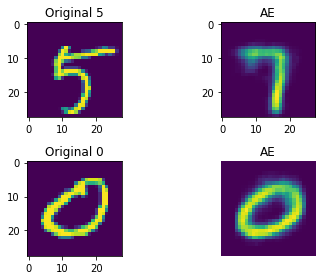

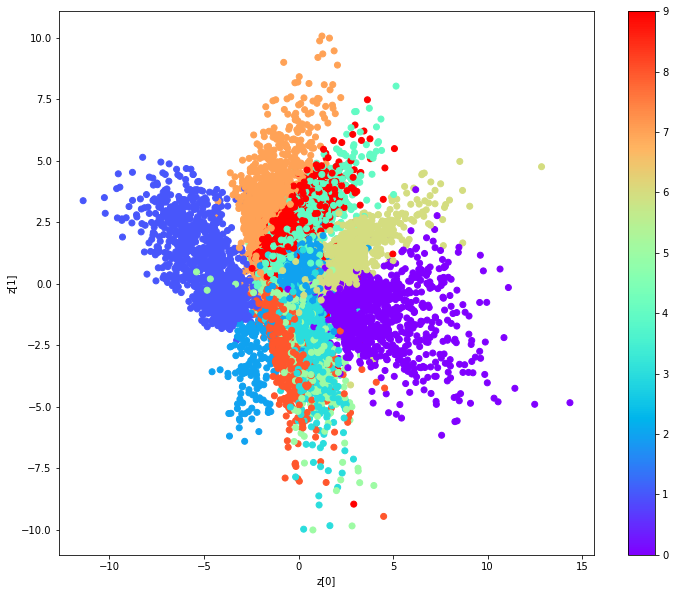

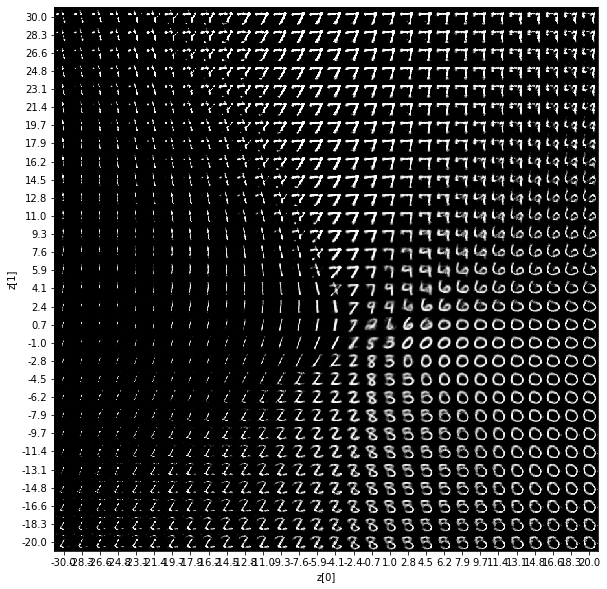

In [0]:
# Results visualization

def ae_view(models, data, range_=((0,12),(0,12)), scatter_points=10000, scatter_figsize=(12,10), cmap=plt.cm.rainbow):
    '''
    Show AutoEncoder's result

    Args:
        models: tuple. (entire ae, encoder part, decoder part)
        data: tuple. (autoencoder's inputs, labels). Using these data.
        range_: (Optional) range to visualize
        scatter_points: (Optional) Number of point to scatter
        scatter_figsize: (Optional) figsize for scatter
        cmap: (Optional) matplotlib cmap to scatter plot. ex. plt.cm.Blues, plt.cm.Reds, ...
    '''
    # Params interpret
    ae, encoder, decoder = models
    x, y = data
    latent_dim = K.int_shape(decoder.get_input_at(0))[1]
    shape = x[0].shape
    ndim = len(shape)
    if ndim == 3:
        if shape[-1] == 1:
            data_type = 'gray'
        else:
            data_type = 'rgb'
    else:
        data_type = 'not image'

    # Show compare image
    if data_type != 'not image':
        compare_image(ae, data, data_type)

    # Visualize latent space
    if latent_dim == 2:
        scatter_on_latent_space(encoder, data, n=scatter_points, figsize=scatter_figsize, cmap=cmap)
    ae_images(decoder, range_=range_)

def ae_images(decoder, range_=((0,12),(0,12))):
    '''
    Visualize manifold

    Args:
        decoder: decoder part
        range_: (Optional) range to visualize
    '''
    # display a 30x30 2D manifold of the digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(range_[0][0], range_[0][1], n)
    grid_y = np.linspace(range_[1][0], range_[1][1], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])
            x_decoded = decoder.predict(z)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

def compare_image(ae, data, image_type):
    '''
    Show and compare
    original, ae output image

    Args:
        ae: entire autoencoder
        data: tuple. (autoencoder inputs, labels)
        image_type: 'gray' or 'rgb'. 'gray' - 1 channel, 'rgb' - 3 channel
    '''
    x,y = data
    for i in [0,2]:
        n = np.random.randint(len(x))
        # Original data
        plt.subplot(2, 2, i+1)
        plt.title('Original ' + str(y[n]))
        if image_type == 'gray':
            plt.imshow(x[n].reshape(28,28))
        elif image_type == 'rgb':
            plt.imshow(x[n])
        # AutoEncoder output
        plt.subplot(2, 2, i+2)
        plt.title('AE')
        if image_type == 'gray':
            plt.imshow(ae.predict_on_batch(x[n:n+1]).reshape(28,28))
        elif image_type == 'rgb':
            plt.imshow(ae.predict_on_batch(x[n:n+1]))
    plt.tight_layout()
    plt.axis('off')
    plt.show()

def scatter_on_latent_space(encoder, data, n=10000, figsize=(12,10), cmap=plt.cm.rainbow):
    '''
    Scatter plot on 2D latent space

    Args:
        encoder: Encoder part
        data: tuple (encoder's input, label).
        n: (Optional) Number of point to scatter
        figsize: (Optional) Figure size
        cmap: (Optional) matplotlib cmap. ex. plt.cm.Blues, plt.cm.Reds, ...
    '''
    # Data
    x_data,y_data = data
    # Size
    plt.figure(figsize=figsize)
    # Scatter
    z = encoder.predict(x_data[:n])
    plt.scatter(z[:, 0], z[:, 1], c=y_data[:n], cmap=cmap)
    # Show
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

data = (x_test, y_test)
ae_view((ae.ae, ae.encoder, ae.decoder), data, range_=((-30,20),(-20,30)))
